# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть InceptionResNetV2  и дообучить под нашу задачу. 


In [15]:
!nvidia-smi

Thu Oct 15 13:38:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    24W /  75W |    209MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
#Импортируем библиотеки:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [17]:
!pip freeze > requirements.txt

In [18]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

# Основные настройки

In [19]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 7  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 299 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/My Drive/Colab Notebooks/data/'
PATH = "/content/drive/My Drive/Colab Notebooks/data/car/" # рабочая директория

In [20]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [21]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

train_df = pd.read_csv(DATA_PATH + 'train.csv')
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [22]:
sample_submission.head()

,Id,Category
0,305108.jpg,0
1,295075.jpg,0
2,31197.jpg,0
3,93598.jpg,0
4,87877.jpg,0


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [24]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [25]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


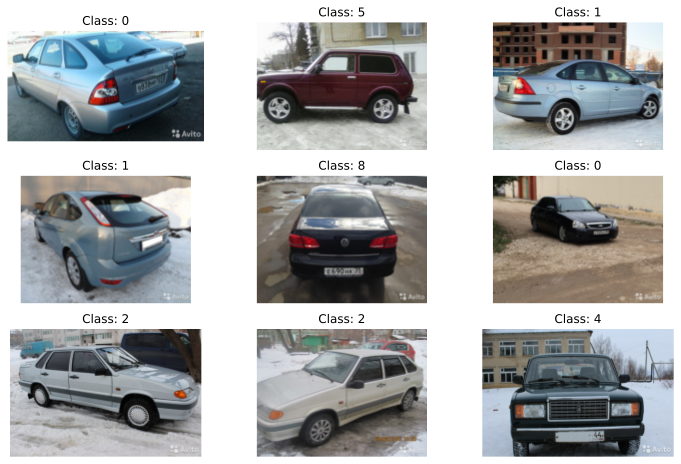

In [26]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

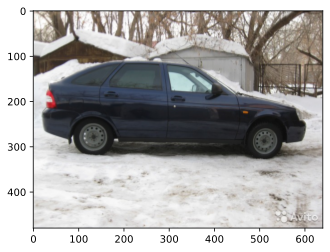

(640, 480)

In [27]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [28]:
# Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

### Генерация данных

In [29]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Построение модели

### Загружаем предобученную сеть InceptionResNetV2:

In [34]:
#base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
#base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

16711680/16705208 [==============================] - 0s 0us/step


In [45]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape = input_shape)

219062272/219055592 [==============================] - 2s 0us/step


In [46]:
base_model.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [47]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x) - ухудшила результат в данном примере
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [48]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [49]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

Обучаем:

In [50]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)


Epoch 1/7
1654/1654 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.8303
Epoch 00001: saving model to best_model.hdf5
1654/1654 [==============================] - 767s 464ms/step - loss: 0.4973 - accuracy: 0.8303 - val_loss: 0.2649 - val_accuracy: 0.9188
Epoch 2/7
1654/1654 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9333
Epoch 00002: saving model to best_model.hdf5
1654/1654 [==============================] - 765s 463ms/step - loss: 0.1865 - accuracy: 0.9333 - val_loss: 0.1874 - val_accuracy: 0.9433
Epoch 3/7
1654/1654 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9578
Epoch 00003: saving model to best_model.hdf5
1654/1654 [==============================] - 764s 462ms/step - loss: 0.1231 - accuracy: 0.9578 - val_loss: 0.2226 - val_accuracy: 0.9309
Epoch 4/7
1654/1654 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9614
Epoch 00004: saving model to best_model.hdf5
1654/1654 [==========

In [51]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../model_last.hdf5')
model.load_weights('best_model.hdf5')

In [52]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 75s 255ms/step - loss: 0.1666 - accuracy: 0.9523
Accuracy: 95.23%


В Итоге точность нашей модели составила 95,23%. 
Учитывая что классов 10 - это Очень хороший результат!     
Посмотрим графики обучения:

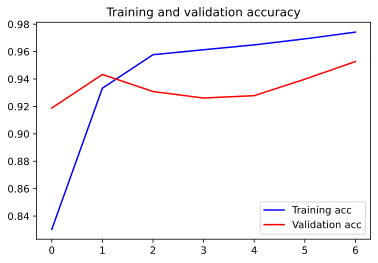

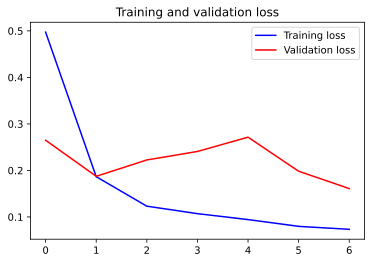

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [54]:
test_sub_generator.samples

6675

In [55]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

Instructions for updating:
Please use Model.predict, which supports generators.
835/835 [==============================] - 105s 126ms/step


In [56]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')


Save submit


In [57]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


In [14]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

# Выводы:

* Среди моих экспериментов архитектура InceptionResNetV2 показала самый лучший результат и посчиталась доматточно быстро.
Также в этом экперименте брала архитектуру EfficientNetB3, но она показала низкий результат на тех же параметрах.
В целом я поняла, что использовать предобученную сеть очень эффективно, главное, подобрать сеть, максимально подходящую под наш задачу и подобрать под нее првильные параметры и "голову".
Мои экперименты с transfer learning с fine-tuning, настройками LR, подбером других переменных (размер картинки, батч и т.д.),  
экспериментируйты с архитектурой “головы”, добавление ТТА можно увидеть  вдругом ноубуке.
